In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import tensorflow as tf

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")

# # No GPU found


from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from tensorflow.keras.callbacks import ModelCheckpoint

from tabulate import tabulate

titles_str = ['bumper_dent','bumper_scratch','door_dent','door_scratch',
              'glass_shatter','head_lamp','no_damage','smash','tail_lamp']
num_classes = len(titles_str)

# **Loading dataset**

In [3]:
batch_size = 32
img_height = 224
img_width = 224

# from google.colab import drive
# drive.mount('/content/gdrive')

## Mount Google drive

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/Peltarion v1/dataset/train/Image', 
    'dataset/train',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42
)


val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'gdrive/MyDrive/Peltarion v1/dataset/validation/Image', 
    'dataset/validation',
    label_mode='categorical', color_mode='rgb', 
    batch_size=32, image_size=(224, 224), seed=42
)

Found 1209 files belonging to 9 classes.
Found 303 files belonging to 9 classes.


## Show the data

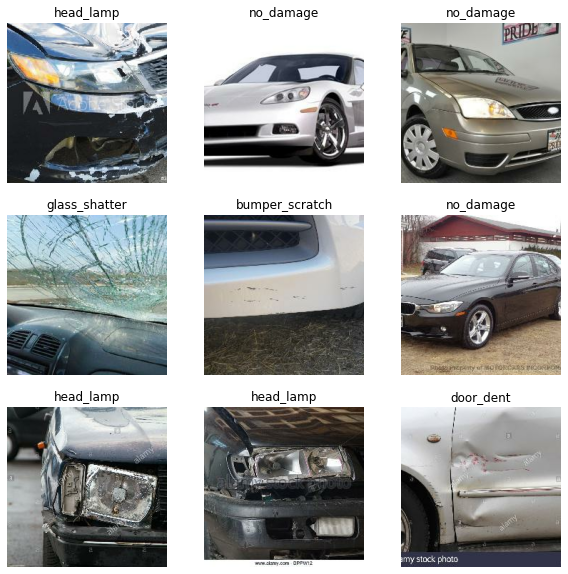

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  
  titles = tf.argmax(labels, axis=1).numpy().tolist()

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(titles_str[titles[i]])
    plt.axis("off")

## Resize, rescale and augment functions

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  # layers.experimental.preprocessing.Rescaling(1./255)
])

## Augment the dataset, preprocess and optimization functions

In [8]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  
  # preprocess for VGG16
  ds = ds.map(lambda x, y: (preprocess_input(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

# **Model definition**

## Model architecture

In [9]:
num_classes = len(titles_str)

resnet = ResNet50(include_top=False)

for layer in resnet.layers:
	layer.trainable = False

model = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.1),
    layers.Dense(num_classes)
])

# model.summary()

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 9)                

## Checkpoint

In [11]:
filepath = 'model/best_model.epoch{epoch:02d}-accuracy{val_accuracy:.5f}.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint]

# callbacks = []

## Compile and train

In [12]:
num_of_reruns = 1 # number of times to train the model again

for i in range(1):    
    model = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.1),
    layers.Dense(num_classes)
    ])
    
    model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    
    epochs = 20
    history = model.fit(
      train_dataset,
      validation_data=val_dataset,
      epochs=epochs,
      callbacks=callbacks
    )

Epoch 1/20
38/38 [==============================] - 16s 247ms/step - loss: 1.2713 - accuracy: 0.6700 - val_loss: 1.1046 - val_accuracy: 0.7063

Epoch 00001: val_accuracy improved from -inf to 0.70627, saving model to model\best_model.epoch01-accuracy0.70627.hdf5


C:\Users\user\anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
38/38 [==============================] - 6s 146ms/step - loss: 0.2815 - accuracy: 0.9148 - val_loss: 0.9600 - val_accuracy: 0.7657

Epoch 00002: val_accuracy improved from 0.70627 to 0.76568, saving model to model\best_model.epoch02-accuracy0.76568.hdf5
Epoch 3/20
38/38 [==============================] - 6s 149ms/step - loss: 0.0878 - accuracy: 0.9727 - val_loss: 0.8945 - val_accuracy: 0.7690

Epoch 00003: val_accuracy improved from 0.76568 to 0.76898, saving model to model\best_model.epoch03-accuracy0.76898.hdf5
Epoch 4/20
38/38 [==============================] - 6s 149ms/step - loss: 0.0422 - accuracy: 0.9859 - val_loss: 0.9161 - val_accuracy: 0.7855

Epoch 00004: val_accuracy improved from 0.76898 to 0.78548, saving model to model\best_model.epoch04-accuracy0.78548.hdf5
Epoch 5/20
38/38 [==============================] - 6s 148ms/step - loss: 0.0191 - accuracy: 0.9934 - val_loss: 0.9129 - val_accuracy: 0.7954

Epoch 00005: val_accuracy improved from 0.78548 to 0.79538, sa

## Visualize training results

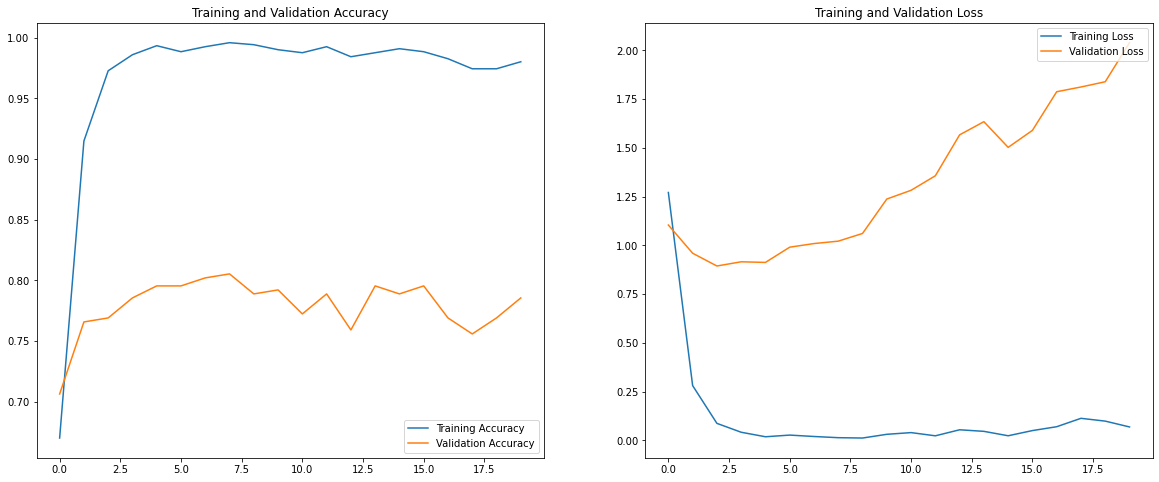

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plt.style.use("dark_background")
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# **Identifying weakness of the model**

## Import best resnet50 model

In [16]:
from keras.models import load_model
model = load_model('model/best_model.epoch05-accuracy0.82838.hdf5')

## Tabulate results

In [17]:
table = [["class", "acc"]]
for cl in titles_str:
    table[0].append(cl)

    row = []
    row.append(cl)

    # cl = 'door_scratch'

    temp_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    #     'gdrive/MyDrive/Peltarion v1/dataset/validation/Image', 
        'dataset_for_eval/validation/' + cl,
        label_mode='categorical', color_mode='rgb', 
        batch_size=32, image_size=(224, 224), seed=42
    )

    correct = titles_str.index(cl)
    predictions = tf.math.argmax(tf.nn.softmax(model.predict(temp_dataset)), axis=1).numpy()

    len_cl = len(predictions)
    accuracy = round(np.count_nonzero(predictions == correct)/len_cl, 3)

    wrong_percentage = np.zeros(num_classes)

    for p in predictions:
        if p != correct:
            wrong_percentage[p] += 1

    wrong_percentage = wrong_percentage/len_cl
    wrong_percentage = np.around(wrong_percentage, 3) # round to 3 decimal places
    wrong_percentage = wrong_percentage.tolist()
    wrong_percentage[correct] = 'NA'

    for index, i in enumerate(wrong_percentage):
        if i == 0.0:
            wrong_percentage[index] = 0

    row.append(accuracy)

    for w in wrong_percentage:
        row.append(w)
        
    table.append(row)

Found 26 files belonging to 1 classes.
Found 16 files belonging to 1 classes.
Found 39 files belonging to 1 classes.
Found 31 files belonging to 1 classes.
Found 27 files belonging to 1 classes.
Found 27 files belonging to 1 classes.
Found 66 files belonging to 1 classes.
Found 44 files belonging to 1 classes.
Found 27 files belonging to 1 classes.


In [18]:
print(tabulate(table, headers="firstrow"))

class             acc  bumper_dent    bumper_scratch    door_dent    door_scratch    glass_shatter    head_lamp    no_damage    smash    tail_lamp
--------------  -----  -------------  ----------------  -----------  --------------  ---------------  -----------  -----------  -------  -----------
bumper_dent     0.808  NA             0.115             0.038        0               0                0.038        0            0        0
bumper_scratch  0.438  0.312          NA                0            0               0                0.125        0            0        0.125
door_dent       0.821  0              0                 NA           0.077           0.051            0            0.026        0.026    0
door_scratch    0.774  0              0                 0.194        NA              0                0            0.032        0        0
glass_shatter   0.778  0.037          0                 0.037        0               NA               0.037        0.037        0.074    0
head_

In [19]:
print("Most common misclassifications")
print("===============================")
table2 = [["class", "acc", "wrong class", "wrong class %"]]
for row in table[1:]:
    r = []
    r.append(row[0])
    r.append(row[1])
    
    maximum = 0
    max_idx = 0
    for index, j in enumerate(row[2:]):
        if type(j)!=str:
            if j > maximum:
                maximum = j
                max_idx = index
    
    r.append(titles_str[max_idx])
    r.append(maximum)
    
    table2.append(r)

print(tabulate(table2, headers="firstrow"))

Most common misclassifications
class             acc  wrong class       wrong class %
--------------  -----  --------------  ---------------
bumper_dent     0.808  bumper_scratch            0.115
bumper_scratch  0.438  bumper_dent               0.312
door_dent       0.821  door_scratch              0.077
door_scratch    0.774  door_dent                 0.194
glass_shatter   0.778  smash                     0.074
head_lamp       0.815  tail_lamp                 0.074
no_damage       0.909  door_dent                 0.045
smash           0.932  no_damage                 0.045
tail_lamp       0.852  bumper_dent               0.111


## Own analysis (not upto date)

When the doors are dented, they also have scratches sometimes (the classes are not mutually exclusive). Same effect is seen with bumper dent and bumper scratch.<br>
Maybe a binary classifier could work better for head lamp vs tail lamp. Head lamp is usually red.

One thing we could do is make scratch the same as in (IEEE) paper. They also separated unkonwn into **no damage** and **smash**. They got 88.24% with a linear softmax classifier (pretrained on ResNet).<br>
We get 81.18% with 2 dense layers pretrained on ResNet.

Further research: make the classes non-mutually exclusive (create own dataset).<br>
Train with linear softmax classifier/linear SVM.<br>